# Libraries

In [33]:
import pickle
from datetime import datetime
import pytz
import pandas as pd
import seaborn as sns
from os.path import exists
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

# Loading the Files

Download the csv files into the `data/` directory.

train.csv shape is  (1697533, 9)
test.csv shape is  (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays wit

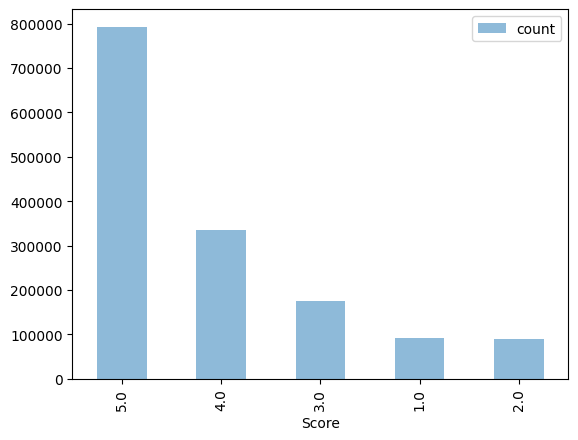


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [34]:
trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")

print("train.csv shape is ", trainingSet.shape)
print("test.csv shape is ", testingSet.shape)

print()

print(trainingSet.head())
print(trainingSet.columns)
print()
print(testingSet.head())

print()

print(trainingSet.describe())

trainingSet['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()

print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [35]:
def add_features_to(df):
    # feature extraction

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    

    df['TextLen'] = df['Text'].fillna('').apply(len)
   
    df['SummaryLen'] = df['Summary'].fillna('').apply(len)

    df['ReviewTime'] = pd.to_datetime(df['Time'], unit='s')

    df['Year'] = df['ReviewTime'].dt.year
    df['Month'] = df['ReviewTime'].dt.month
    df['Day'] = df['ReviewTime'].dt.day
    # df['DayOfWeek'] = df['ReviewTime'].dt.dayofweek


    # day_of_week_encoded = pd.get_dummies(df['DayOfWeek'], prefix='DayOfWeek', drop_first=True).astype(int)
    # df = pd.concat([df, day_of_week_encoded], axis=1)

    # Initialize VADER sentiment analyzer
    # sid = SentimentIntensityAnalyzer()
    
    # # Apply VADER sentiment scores to each review text
    # sentiment_scores = df['Text'].fillna('').apply(sid.polarity_scores)
    # df['Positive'] = sentiment_scores.apply(lambda x: 1 if x['pos'] > 0 else 0)
    # df['Negative'] = sentiment_scores.apply(lambda x: 1 if x['neg'] > 0 else 0)
    # df['Neutral'] = sentiment_scores.apply(lambda x: 1 if x['neu'] > 0 else 0)
    
    return df




# Load the feature extracted files if they've already been generated
if exists('./data/X_train.csv'):
    print("X_TRAIN EXISTS ALREADY")
    X_train = pd.read_csv("./data/X_train.csv")
if exists('./data/X_submission.csv'):
    print("X_SUBMISSION EXIST ALREADY")
    X_submission = pd.read_csv("./data/X_submission.csv")

else:
    # Process the DataFrame
    train = add_features_to(trainingSet)
    
   

    # Merge on Id so that the submission set can have feature columns as well
    X_submission = pd.merge(train, testingSet, left_on='Id', right_on='Id')
    X_submission = X_submission.drop(columns=['Score_x'])
    X_submission = X_submission.rename(columns={'Score_y': 'Score'})

    # The training set is where the score is not null
    X_train =  train[train['Score'].notnull()]

    X_submission.to_csv("./data/X_submission.csv", index=False)
    X_train.to_csv("./data/X_train.csv", index=False)

# Sample + Split into training and testing set

In [36]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X_train,
    X_train['Score'],
    test_size=1/4.0,
    random_state=123, 
    stratify = X_train['Score']
)

user_stats = X_train.groupby('UserId')['Score'].agg(['mean', 'std']).reset_index().rename(columns={'mean': 'User_avg_score', 'std': 'User_std_score'})
product_stats = X_train.groupby('ProductId')['Score'].agg(['mean', 'std']).reset_index().rename(columns={'mean': 'Product_avg_score', 'std': 'Product_std_score'})

def compute_mode_proportion(df, group_col, target_col):
    mode_df = df.groupby(group_col)[target_col].agg(
        lambda x: x.mode().iloc[0] if not x.mode().empty else x.iloc[0]).reset_index().rename(columns={target_col: f'{group_col}_mode_score'})
    proportion_df = df.groupby(group_col)[target_col].apply(lambda x: x.value_counts().iloc[0] / len(x)).reset_index().rename(columns={target_col: f'{group_col}_mode_proportion'})
    return pd.merge(mode_df, proportion_df, on=group_col)

user_mode_proportion = compute_mode_proportion(X_train, 'UserId', 'Score')
product_mode_proportion = compute_mode_proportion(X_train, 'ProductId', 'Score')

user_mode_dict = user_mode_proportion.set_index('UserId').to_dict(orient='index')
product_mode_dict = product_mode_proportion.set_index('ProductId').to_dict(orient='index')

X_train = X_train.drop(columns=['Score'])
X_test = X_test.drop(columns=['Score'])


#, 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6']

features = ['Helpfulness', 'TextLen', 'SummaryLen', 'Day', 'Month', 'Year', 'UserId', 'ProductId']


X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# # Check the data type of 'DayOfWeek_1'
# day_of_week_1_dtype = X_train_select['DayOfWeek_1'].dtype
# print(day_of_week_1_dtype)
# # Print the first value of the 'DayOfWeek_1' column
# print(X_train_select['DayOfWeek_1'].iloc[0])

X_train_select = pd.merge(X_train_select, user_stats, on='UserId', how='left')
X_test_select = pd.merge(X_test_select, user_stats, on='UserId', how='left')
X_submission_select = pd.merge(X_submission_select, user_stats, on='UserId', how='left')

X_train_select = pd.merge(X_train_select, product_stats, on='ProductId', how='left')
X_test_select = pd.merge(X_test_select, product_stats, on='ProductId', how='left')
X_submission_select = pd.merge(X_submission_select, product_stats, on='ProductId', how='left')

meanscore = Y_train.mean()
for df in [X_train_select, X_test_select, X_submission_select]:
    df['User_avg_score'] = df['User_avg_score'].fillna(meanscore)
    df['User_std_score'] = df['User_std_score'].fillna(0)
    df['Product_avg_score'] = df['Product_avg_score'].fillna(meanscore)
    df['Product_std_score'] = df['Product_std_score'].fillna(0)

def mergeMode(df, group_col, mode_dict):
    df[f'{group_col}_mode_score'] = df[group_col].map(
        lambda x: mode_dict[x][f'{group_col}_mode_score'] if x in mode_dict else meanscore)
    df[f'{group_col}_mode_proportion'] = df[group_col].map(
        lambda x: mode_dict[x][f'{group_col}_mode_proportion'] if x in mode_dict else 0)
    return df

X_train_select = mergeMode(X_train_select, 'UserId', user_mode_dict)
X_test_select = mergeMode(X_test_select, 'UserId', user_mode_dict)
X_submission_select = mergeMode(X_submission_select, 'UserId', user_mode_dict)

X_train_select = mergeMode(X_train_select, 'ProductId', product_mode_dict)
X_test_select = mergeMode(X_test_select, 'ProductId', product_mode_dict)
X_submission_select = mergeMode(X_submission_select, 'ProductId', product_mode_dict)


features = [
    'Helpfulness', 'Year', 'Month', 'Day',
    'SummaryLen', 'TextLen', 'User_avg_score', 'User_std_score', 'Product_avg_score',
    'Product_std_score', 'UserId_mode_score', 'UserId_mode_proportion', 'ProductId_mode_score',
    'ProductId_mode_proportion'
]

X_train_select = X_train_select[features]
X_test_select = X_test_select[features]
X_submission_select = X_submission_select[features]

tfidf_summary = TfidfVectorizer(max_features=500, stop_words='english')
tfidf_text = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_summary.fit(X_train['Summary'].fillna(''))
tfidf_text.fit(X_train['Text'].fillna(''))

summary_train_tfidf = tfidf_summary.transform(X_train['Summary'].fillna(''))
text_train_tfidf = tfidf_text.transform(X_train['Text'].fillna(''))
summary_test_tfidf = tfidf_summary.transform(X_test['Summary'].fillna(''))
text_test_tfidf = tfidf_text.transform(X_test['Text'].fillna(''))
summary_submission_tfidf = tfidf_summary.transform(X_submission['Summary'].fillna(''))
text_submission_tfidf = tfidf_text.transform(X_submission['Text'].fillna(''))

X_train_stacked = hstack([X_train_select, summary_train_tfidf, text_train_tfidf])
X_test_stacked = hstack([X_test_select, summary_test_tfidf, text_test_tfidf])
X_submission_stacked = hstack([X_submission_select, summary_submission_tfidf, text_submission_tfidf])



# Model Creation

Accuracy from GridSearchCV:  0.621421031087748


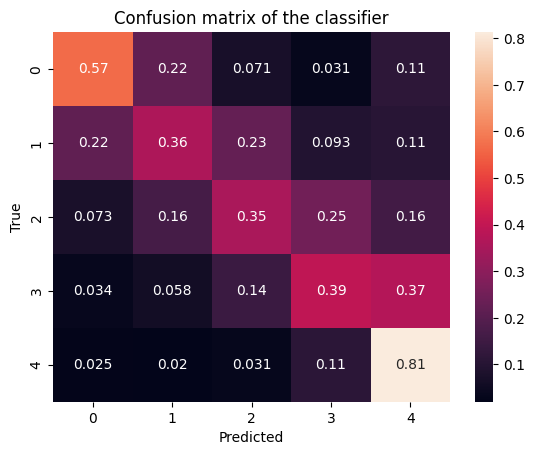

In [38]:


scale = StandardScaler(with_mean = False)
X_train_new = scale.fit_transform(X_train_stacked)
X_test_new = scale.transform(X_test_stacked)
X_submission_new = scale.transform(X_submission_stacked)



X_train_final, _, Y_train_final, _ = train_test_split(
    X_train_new, Y_train, train_size=100000, random_state=123, stratify=Y_train
)

param_grid = {'C': [0.1, 1, 2, 3], 'loss': ['squared_hinge']}
svc = LinearSVC(random_state=123, max_iter=10000, dual=False, class_weight='balanced')

gs = GridSearchCV(estimator=svc, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1)
gs.fit(X_train_final, Y_train_final)

model = gs.best_estimator_

# Predicting on the test set
Y_test_predictions = model.predict(X_test_new)

accuracy = accuracy_score(Y_test, Y_test_predictions)
print("Accuracy from GridSearchCV: ", accuracy)
      

# model = RandomForestClassifier(n_estimators = 100, max_depth = None, n_jobs = -1, class_weight = "balanced", random_state = 123)
# model.fit(X_train_select, Y_train)
# Y_test_predictions = model.predict(X_test_select)
# accuracy = accuracy_score(Y_test, Y_test_predictions)
# print("Random Forest Model Accuracy: ", accuracy)



cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()




In [40]:
# Create the submission file
X_submission['Score'] = model.predict(X_submission_new)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)